## ROC Curves
This notebook demonstrates the code for comparing ROC (Receiver Operating Characteristic) scores across different classifier models.

In [1]:
#import the right libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, log_loss, roc_auc_score, hamming_loss, fbeta_score, auc, roc_curve, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn import metrics
plt.rcParams["figure.figsize"] = (9,9)

In [2]:
#this option just allwos us to see every column in the notebook
pd.set_option('display.max_columns', None)

#pd.get_option("display.max_columns")

In [3]:
#pull in the dataset and turn into a DataFrame
bank_main_df = pd.read_csv('./Dataset_1_Bank Marketing/bank_marketing.csv',delimiter=';')
bank_main_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,58.0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44.0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33.0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47.0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33.0,unknown,single,unknown,no,1,no,no,NaN,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51.0,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71.0,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72.0,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57.0,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [4]:
bank_main_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,43872.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.924781,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.610835,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
#creating a field that determines whether or not the customer was ever previously contacted
bank_main_df['prior_contact'] = [ 0 if bank_main_df['pdays'][i] == -1 else 1 for i in range(len(bank_main_df))]

#replacing the yes/no categorical values with 1/0 binary digits
bank_main_df['deposit'] = [0 if (bank_main_df['deposit'][i] == 'yes') else 1 for i in range(len(bank_main_df)) ]

#convert the "day" field to a categorical variable
bank_main_df['day'] = pd.Categorical(bank_main_df['day'])

#dropping pdays and previous, because the important information is captured in prior_contact
bank_main_df.drop(columns=['pdays','previous','job','marital','education','default','housing','loan','contact','month','duration'],inplace=True)

In [6]:
#because we have so many cateogrical variables, we should one-hot encode them (i.e. create dummy categorical variables)
#we also use drop_first=True to reduce the redundant column count 
bank_main_df = pd.get_dummies(bank_main_df, drop_first=False)

# bank_main_df

In [7]:
#note that only the "age" category has null values

# pd.isnull(bank_main_df).sum()

# Imputing the missing values in "Age" variable 

* **Iterative Imputer:**
Multivariate imputer that estimates each feature from all the others. A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

In [8]:
# Use multivariate imputer that estimates and imputes null values based on all the others. 

imp = IterativeImputer(max_iter=10, verbose=0) # values passed are defaults, but added them because they seem important... play around
imp.fit(bank_main_df)
imputed_df = imp.transform(bank_main_df)
imputed_df = pd.DataFrame(imputed_df, columns=bank_main_df.columns)

### Scaling the data (Standard, MinMax, Robust)

In [16]:
# StandardScaler, MinMaxScaler, RobustScaler
#scaler = RobustScaler() 
#scaler = MinMaxScaler() 
#scaler = StandardScaler() 

X = imputed_df.drop(columns='deposit')
y = imputed_df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=True)

scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# R-Forest Feature Importance

C:\Users\trevor.sauerbrey\WPy64-3890\python-3.8.9.amd64\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


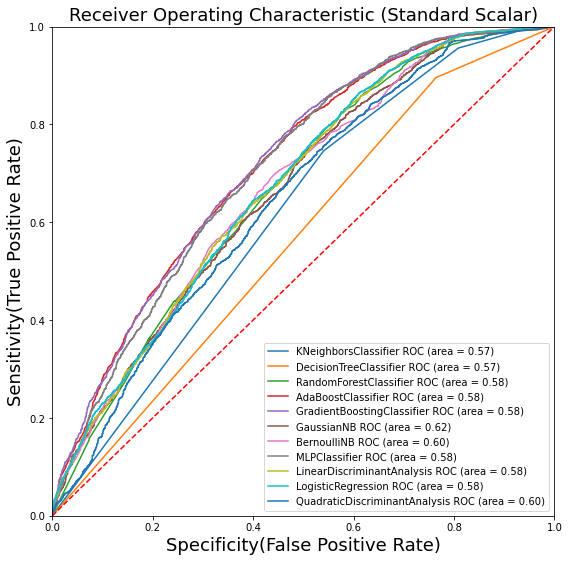

In [18]:
# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'KNeighborsClassifier',
    'model': KNeighborsClassifier(3),
},
{
    'label': 'DecisionTreeClassifier',
    'model': DecisionTreeClassifier(),
},
    {
    'label': 'RandomForestClassifier',
    'model': RandomForestClassifier(),
},
    {
    'label': 'AdaBoostClassifier',
    'model': AdaBoostClassifier(),
},
    {
    'label': 'GradientBoostingClassifier',
    'model': GradientBoostingClassifier(),
},
    {
    'label': 'GaussianNB',
    'model': GaussianNB(),
},
    {
    'label': 'BernoulliNB',
    'model': BernoulliNB(),
},
    {
    'label': 'MLPClassifier',
    'model': MLPClassifier(),
},
    {
    'label': 'LinearDiscriminantAnalysis',
    'model': LinearDiscriminantAnalysis(),
},
    {
    'label': 'LogisticRegression',
    'model': LogisticRegression(),
},
    {
    'label': 'QuadraticDiscriminantAnalysis',
    'model': QuadraticDiscriminantAnalysis(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Specificity(False Positive Rate)', fontsize=18)
plt.ylabel('Sensitivity(True Positive Rate)', fontsize=18)
plt.title('Receiver Operating Characteristic (Standard Scalar)', fontsize=18)
plt.legend(loc="lower right")
plt.show()   # Display